In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import KFold, train_test_split

## Loading Data

In [18]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

## Missing Data    

In [19]:
'''functions to check the number of null values '''

null_columns = train_df.columns[train_df.isna().any()] 
train_df[null_columns ].isna().sum().sort_values(ascending=False) # return number of null values

line             3524
floornumber      1277
year_built        403
min_to_subway     126
unit               95
addr_unit          91
description        15
neighborhood        3
bin                 1
dtype: int64

In [20]:
#train_df['borough']=pd.to_numeric(train_df['borough'],errors='coerce')
#train_df['addr_city']=pd.to_numeric(train_df['addr_city'],errors='coerce')
#train_df['neighborhood']=pd.to_numeric(train_df['neighborhood'],errors='coerce')

#train_df.dtypes

In [21]:
#train_df=train_df.drop_duplicates()


## Handle Training Data Missing Values

In [22]:
'''input 
    df=DataFrame
    feature=string
    
    output
    df=DataFrame
'''
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)    
    return df

In [23]:
feature_cols = ['min_to_subway',
                'size_sqft', 
                'bathrooms', 
                'bedrooms',
             'floor_count', 
           'floornumber',  
          'borough'
               ]

train_features = train_df[feature_cols] 
#train_features=random_imputation(train_features,'floornumber')
#train_features=random_imputation(train_features,'min_to_subway')

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']

In [25]:
train_features = pd.get_dummies(train_features)

- change Borough String to boolean (0 ,1)

## Visualization


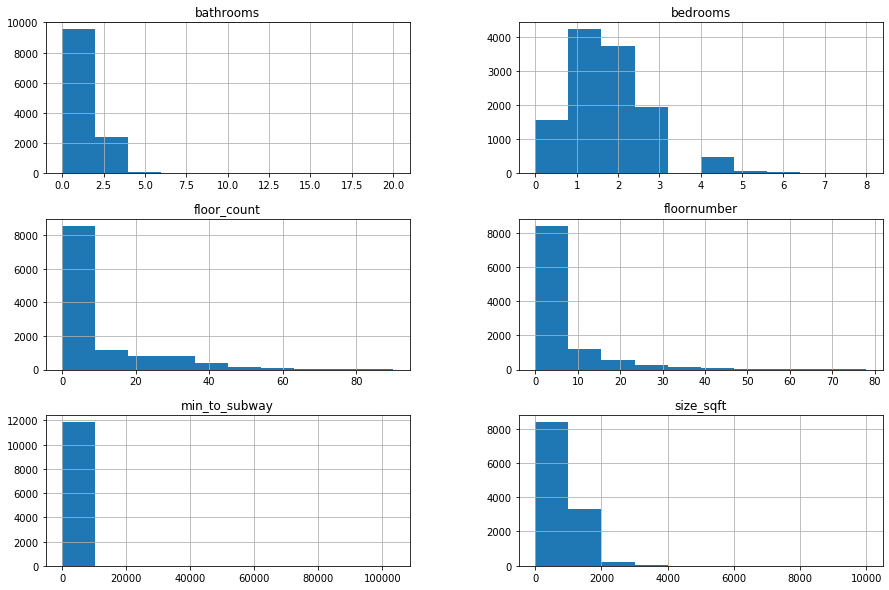

In [26]:

train_df[feature_cols].hist(figsize=(15,10))
plt.show()

- Visualization on the Histogram of all features that we will be using. 



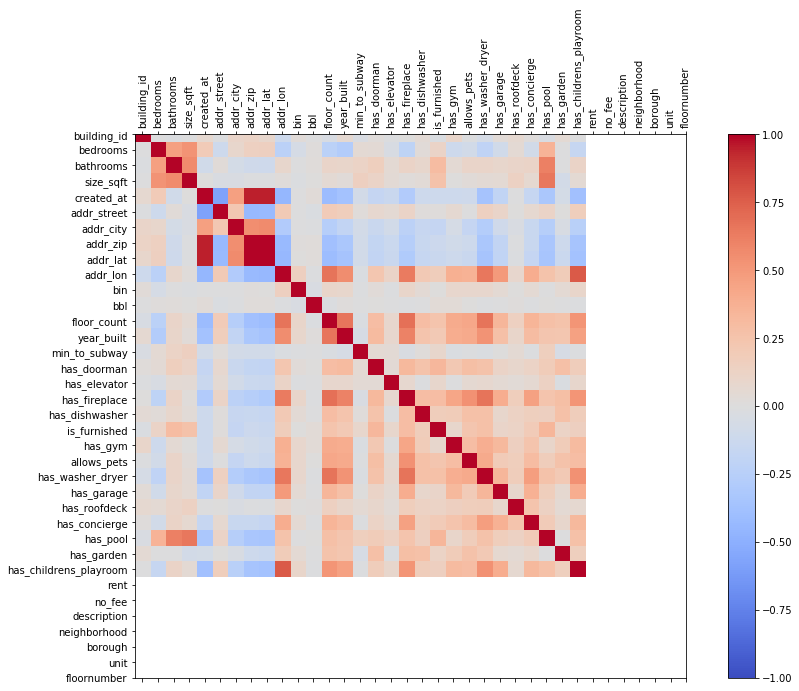

In [27]:
train_df=train_df.iloc[:,1:-1]
corr = train_df.corr()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_df.columns)
ax.set_yticklabels(train_df.columns)
plt.show()

- Checking the correlation between two variables.
- Darkest Red indicates positive correlation
- Darkes Blues indicates negative correlation

## Linear and Gradient Boosting Model

In [28]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

gb = GradientBoostingRegressor()
gb.fit(train_features, train_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
test_features = test_df[feature_cols] 

# impute missing values with medians
#test_features=random_imputation(test_features,'floornumber')

test_features = test_features.fillna(train_features.median(), axis=0)
test_features = pd.get_dummies(test_features)

# construct predictions 
test_df['predicted'] = gb.predict(test_features)

mean_squared_error(test_df['rent'], test_df['predicted'])

2342110.872132872

In [30]:

test1_features = test_df[feature_cols] 
test1_features = test1_features.fillna(train_features.median(), axis=0)

In [31]:
master_df = train_df.append(test_df, sort=False)

master_features = master_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
master_features = pd.get_dummies(master_features)

master_target = master_df['rent']


gb.fit(master_features, master_target)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
submit2_features = submit2_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)

submit2_features = pd.get_dummies(submit2_features)

submit2_df['predictions'] = gb.predict(submit2_features)
submit2_df['predictions'].to_csv('sample_submission2.csv', header=True)

submit2_df['fake_rent'] = np.ones(submit2_df['predictions'].shape) * master_target.median()
mean_squared_error(submit2_df['predictions'], submit2_df['fake_rent'])

5045881.04036944